## Objective

Objective is to identify the most important aspects of a song that affect whether or not is playlisted, as well as to predict whether or not a song will be playlisted based on those aspects. Every artist on Spotify knows the importance of being added to a Spotify editorial playlist. As an artist myself, I could wake up to the notification that a song of mine had been added to a playlist and watch my song gain thousands of streams a day. One of the best playlists to be added to in the indie genre is 'undercurrents.'

## Creating the Data

Using spotipy, I pulled the tracks and artist names from 'undercurrents,' and created a dataset of every artist's discography with an indicator variable = 1 if the song is on 'undercurrents' and 0 otherwise. I then wrote a function that added features of every track to the dataset. Up next, I scaled the features and dropped any songs that did not have features available. The resulting dataset 1535 songs by 64 unique artists with 10 song features.

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np

auth_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(auth_manager=auth_manager)

# returns dataframe of all playlist tracks, track ids, artists, and artist ids given a playlist uri

def playlist_df(playlist):
    
    results = sp.playlist_tracks(playlist, fields = 'items')
    
    A = []
    B = []
    C = []
    D = []
      
    for i in range(len(results['items'])):
        A.append(results['items'][i]['track']['name'])
        B.append(results['items'][i]['track']['id'])
        C.append(results['items'][i]['track']['artists'][0]['name'])
        D.append(results['items'][i]['track']['artists'][0]['id'])
        
    dict = {'Track': A, 'Track ID': B, 'Artist': C, 'Artist ID': D}  
    
    df = pd.DataFrame(dict)
        
    return df

# returns lists of artist's discography in tracks and ids given artist id
    
def artist_albums(artist_id):
    
    track_ids = []
    albums = []
    tracks = []
    results = sp.artist_albums(artist_id, album_type='album')
    albums.extend(results['items'])
    
    
    while results['next']:
        results = sp.next(results)
        albums.extend(results['items'])
    
    unique = set()  # skip duplicate albums
    
    for album in albums:
        name = album['name'].lower()
        if name not in unique:
            unique.add(name)
            this_tracks, this_id = show_album_tracks(album)
            tracks += this_tracks
            track_ids += this_id
            
    this_tracks, this_id = top_tracks(artist_id)
    
    tracks += this_tracks
    track_ids += this_id
            
    tracks, ids = unique_tracks(tracks, track_ids)
    
    return tracks, ids

# given lists of tracks and ids, returns lists of only unique tracks and ids

def unique_tracks(ls_t, ls_i):
    unique_t = []
    unique_i = []
    for i in range(0,len(ls_t)):
        if ls_t[i] not in unique_t:
            unique_t.append(ls_t[i])
            unique_i.append(ls_i[i])
    return unique_t, unique_i

# given album, returns list of all tracks and track ids from that album

def show_album_tracks(album):
    ids = []
    tracks = []
    track_names = []
    results = sp.album_tracks(album['id'])
    tracks.extend(results['items'])
    
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
        
    for track in tracks:
        track_names.append(track['name'])
        ids.append(track['id'])
   
    return track_names, ids

# function that returns top tracks of artist

def top_tracks(artist_id):
    t = []
    d = []
    tracks = sp.artist_top_tracks(artist_id)
    for i in range(len(tracks['tracks'])):
        t.append(tracks['tracks'][i]['album']['name'])
        d.append(tracks['tracks'][i]['album']['id'])
    return t, d

# function that adds songs to df given current df's artist IDs

def add_songs(df):
    old_df = df 
    
    for i in range(0, len(df['Artist ID'])):
        
        artist = df['Artist'][i]
        artist_id = df['Artist ID'][i]
        
        tracks, ids = artist_albums(artist_id)
        
        for j in range(0, len(tracks)):
            new_df = pd.DataFrame([tracks[j], ids[j], artist, artist_id])
            new_df = new_df.transpose()
            new_df = new_df.rename(columns = {0: 'Track', 1: 'Track ID', 2: 'Artist', 3: 'Artist ID'}, index = {0: len(df['Artist ID'])+ i + 1})
            
            df = df.append(new_df)
        
    df2 = df.sort_values(by = ['Artist'])
    df2 = df2.reset_index(drop = True)


    df2['Playlisted'] = df2['Track'].isin(old_df['Track']).astype(int)
    
    return df2

def features(df):
    
    danceability = []
    energy = []
    key = []
    loudness = []
    mode = []
    speechiness = []
    acousticness = []
    instrumentalness = []
    liveness = []
    valence = []
    tempo = []
    dur = []
    sig = []
    ls = [danceability, energy, key, loudness, mode, speechiness,acousticness, instrumentalness, liveness, valence,
         tempo, dur, sig]
    quotes = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence',
         'tempo', 'duration_ms', 'time_signature']
    
    for id_ in df['Track ID']:
        features = sp.audio_features(id_)
        if features == [None]:
            for item in ls:
                item.append(np.nan)
        else:
            features = features[0]
            for i,j in zip(ls,quotes):
                i.append(features[j])
                
    dic = {'Danceability': danceability, 'Energy': energy, 'Key': key, 'Loudness': loudness, 'Mode': mode,
            'Speechiness': speechiness, 'Acoustic': acousticness, 'Instrumental': instrumentalness,
           'Liveness': liveness, 'Valence': valence, 'Tempo': tempo, 'Dur': dur, 'Sig': sig}
    
    return dic

from sklearn.preprocessing import StandardScaler

def clean(df):
    df = df.dropna()
    df = df.reset_index(drop = True)
    addback = [df['Playlisted'], df['Artist ID'], df['Artist'], df['Track ID'], df['Track'],]
    to_scale = df.drop(columns = ['Playlisted','Track', 'Track ID', 'Artist','Artist ID'])
    scaler = StandardScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(to_scale), columns = to_scale.columns)
    
    for column in addback:
        data_scaled = pd.concat([pd.DataFrame(column), data_scaled], axis = 1)
 
    return data_scaled
    

In [2]:
def main():
    playlist_id = 'spotify:playlist:37i9dQZF1DX9myttyycIxA'
    df = playlist_df(playlist_id)
    df = add_songs(df)
    feats = pd.DataFrame(features(df))
    df = pd.concat([feats, df], axis = 1)
    df = clean(df)
    df.to_csv(r'/Users/harlanhutton/Documents/spotify/undercurrentsdata.csv', index = False)

In [3]:
main()

In [4]:
data = pd.read_csv('/Users/harlanhutton/Documents/spotify/undercurrentsdata.csv')
data = data.drop(columns = ['Track', 'Track ID', 'Artist', 'Artist ID'])
data.describe()

,Playlisted,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acoustic,Instrumental,Liveness,Valence,Tempo,Dur,Sig
count,1535.000000,1.535000e+03,1.535000e+03,1.535000e+03,1.535000e+03,1.535000e+03,1.535000e+03,1.535000e+03,1.535000e+03,1.535000e+03,1.535000e+03,1.535000e+03,1.535000e+03,1.535000e+03
mean,0.081433,5.667562e-16,-2.392223e-16,-9.402540e-18,2.464324e-16,4.044539e-16,-1.399894e-16,5.019510e-17,-1.338054e-17,-2.179400e-16,1.780696e-16,3.694023e-16,-5.804260e-17,4.082149e-16
std,0.273588,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00
min,0.000000,-3.473069e+00,-2.019390e+00,-1.503179e+00,-5.504848e+00,-1.846867e+00,-9.326163e-01,-1.352153e+00,-6.495128e-01,-1.132672e+00,-1.747442e+00,-4.237749e+00,-2.034555e+00,-7.160654e+00
25%,0.000000,-6.854757e-01,-7.810510e-01,-9.376447e-01,-5.547581e-01,5.414574e-01,-2.988738e-01,-1.026224e+00,-6.491983e-01,-5.676936e-01,-8.253855e-01,-7.041348e-01,-5.060949e-01,2.849710e-01
50%,0.000000,4.773749e-02,-3.753491e-02,-8.934336e-02,1.640824e-01,5.414574e-01,-1.983638e-01,3.060128e-02,-6.163751e-01,-4.175594e-01,-1.143471e-01,-1.108247e-03,-1.120568e-01,2.849710e-01
75%,0.000000,7.394481e-01,7.786235e-01,1.041725e+00,7.160686e-01,5.414574e-01,-2.379364e-02,1.038042e+00,3.998468e-01,2.224864e-01,6.494458e-01,6.289989e-01,3.403805e-01,2.849710e-01
max,1.000000,2.946005e+00,2.163102e+00,1.607259e+00,1.944909e+00,5.414574e-01,1.770936e+01,1.455693e+00,2.493832e+00,5.824863e+00,2.752743e+00,3.087657e+00,1.306110e+01,2.146377e+00


## Variable Importance

In [5]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,Playlisted,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acoustic,Instrumental,Liveness,Valence,Tempo,Dur,Sig
Playlisted,1.000000,0.088769,0.059082,-0.019193,0.076781,0.024683,-0.038155,-0.078854,-0.051033,0.003201,0.056215,0.048068,-0.016978,0.053812
Danceability,0.088769,1.000000,-0.005452,0.023790,0.015748,-0.025128,0.035625,-0.011931,-0.142746,-0.070459,0.363832,-0.068440,-0.136983,0.029140
Energy,0.059082,-0.005452,1.000000,0.015551,0.800196,-0.063731,0.055012,-0.706037,0.105800,0.197529,0.498323,0.219343,0.057123,0.127732
Key,-0.019193,0.023790,0.015551,1.000000,-0.001891,-0.187003,0.053008,0.017262,-0.008479,0.045981,0.025964,-0.003637,0.009028,0.058035
Loudness,0.076781,0.015748,0.800196,-0.001891,1.000000,-0.042068,-0.049054,-0.635105,-0.043101,0.118985,0.353029,0.132616,0.020894,0.118742
Mode,0.024683,-0.025128,-0.063731,-0.187003,-0.042068,1.000000,-0.059004,0.035854,-0.024037,-0.038149,-0.031191,0.056892,-0.002881,-0.012387
Speechiness,-0.038155,0.035625,0.055012,0.053008,-0.049054,-0.059004,1.000000,0.055005,0.008280,0.120977,0.036515,0.065625,-0.077364,-0.004675
Acoustic,-0.078854,-0.011931,-0.706037,0.017262,-0.635105,0.035854,0.055005,1.000000,0.071442,-0.117717,-0.362599,-0.141645,-0.045830,-0.108967
Instrumental,-0.051033,-0.142746,0.105800,-0.008479,-0.043101,-0.024037,0.008280,0.071442,1.000000,-0.011595,-0.046572,-0.007322,0.022131,-0.028548
Liveness,0.003201,-0.070459,0.197529,0.045981,0.118985,-0.038149,0.120977,-0.117717,-0.011595,1.000000,0.097181,0.021921,-0.030419,-0.011022


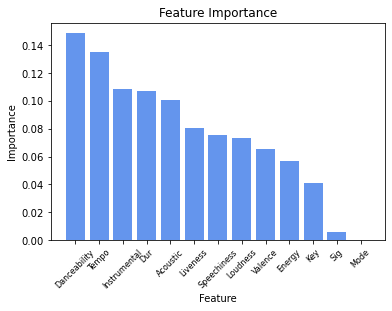

In [6]:
# add features and their importances to a dictionary
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

Y = data['Playlisted']
X = data.drop('Playlisted',1)

dt = DecisionTreeClassifier()
dt.fit(X,Y)
feature_mi = dt.feature_importances_
mi_dict = dict(zip(X.columns.values, feature_mi))

sorted_dict = {k: v for k, v in sorted(mi_dict.items(), reverse = True, key=lambda item: item[1])}

plt.bar(sorted_dict.keys(), sorted_dict.values(), color = 'cornflowerblue')
plt.xticks(range(X.shape[1]), sorted_dict.keys(), fontsize=8, rotation=45)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

count = 0
top5 = []
for key in sorted_dict:
    if count != 5:
        top5.append(key)
        count += 1

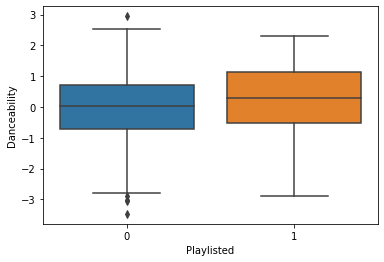

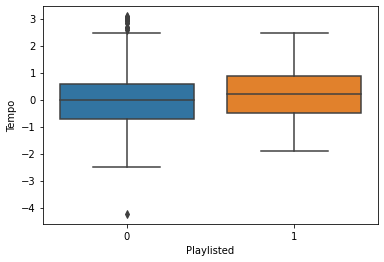

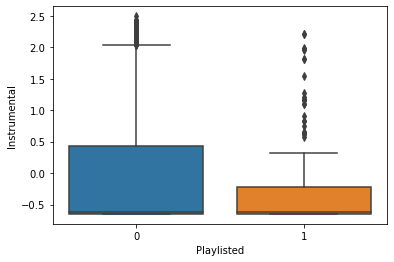

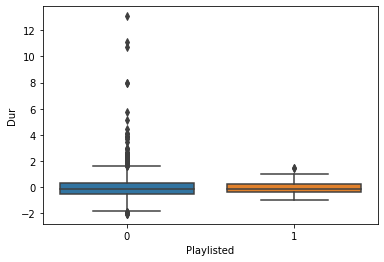

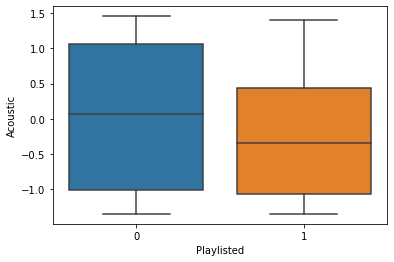

In [7]:
import seaborn as sns

for feature in top5:
    #data.boxplot(column = feature, by = 'Playlisted', fontsize = 10);
    sns.boxplot(x='Playlisted', y=feature, data=data)
    plt.show()

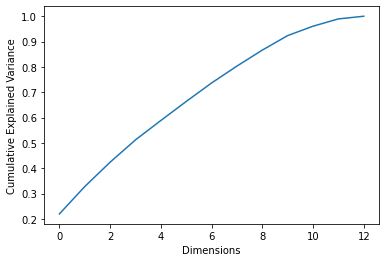

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(X)

pca = PCA().fit(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Dimensions')
plt.ylabel('Cumulative Explained Variance')
plt.show()

<Figure size 432x288 with 0 Axes>

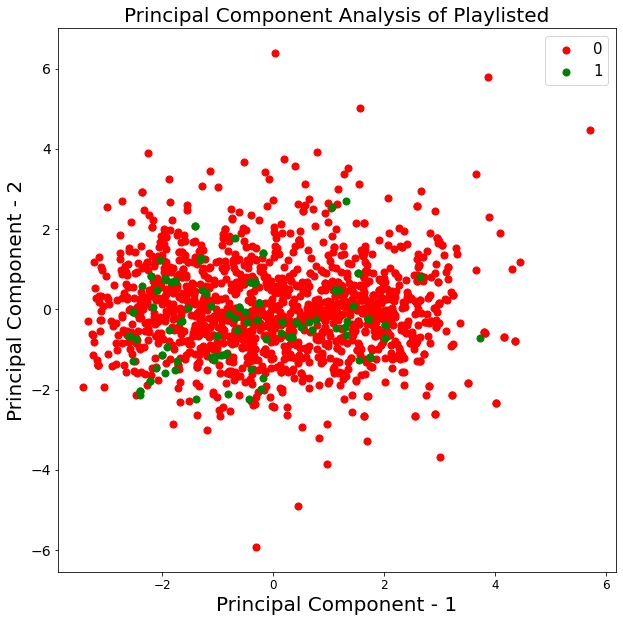

In [9]:
plt.figure();
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Playlisted",fontsize=20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = Y == target
    plt.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2'], c = color, s = 50);

plt.legend(targets,prop={'size': 15})
plt.show();

## Bakeoff

After features analysis, I am going to run a bakeoff for different models. Because my data is imbalanced, I am going to upsample as well. (I will first run the bakeoff on the data without upsampling, and the compare performance of models). Next, I will compare model performance to dataset with dimensionality reduction.

In [10]:
from sklearn.model_selection import *

X_train, X_test, y_train, y_test = train_test_split(data.drop('Playlisted',1), data['Playlisted'], test_size=0.2, random_state=42)
data_train, data_test = pd.concat([X_train, y_train], axis = 1), pd.concat([X_test,y_test], axis = 1)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *

models = [LogisticRegression(),SVC(probability = True), GaussianNB(), RandomForestClassifier(), DecisionTreeClassifier(), KNeighborsClassifier(), GradientBoostingClassifier()]

def plot_roc_curve(models, train, test):
    fpr = []
    tpr = []
    auc = []
    acc = []
    recall = []
    precision = []
    
    X_train = train.drop('Playlisted',1)
    y_train = train['Playlisted']
    
    X_test = test.drop('Playlisted',1)
    y_test = test['Playlisted']
    
    plt.figure(figsize=(20,10))
    
    for model in models:
        
        mod = model.fit(X_train, y_train)
            
        preds = mod.predict_proba(X_test)[:,1]
        this_fpr,this_tpr,thresh = roc_curve(y_test, preds)
        auc.append( roc_auc_score(y_test, preds) )
        fpr.append( this_fpr )
        tpr.append( this_tpr )
        acc.append(accuracy_score(y_test, mod.predict(X_test)))
        recall.append(recall_score(y_test,mod.predict(X_test) ))
        precision.append(precision_score(y_test, mod.predict(X_test), zero_division = 0))
        
        plt.plot(this_fpr,this_tpr, label = mod)
        
        print(mod)
        print(confusion_matrix(y_test, mod.predict(X_test)))
        
    plt.plot([0,1],[0,1], 'b--', label = 'Random Chance')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend();
    
    df = pd.DataFrame(models, columns = ['Model'])
    df['Accuracy'],df['AUC'],df['Recall'],df['Precision'] = acc,auc,recall,precision
    
    return df
    

LogisticRegression()
[[281   0]
 [ 26   0]]
SVC(probability=True)
[[281   0]
 [ 26   0]]
GaussianNB()
[[187  94]
 [ 11  15]]
RandomForestClassifier()
[[281   0]
 [ 13  13]]
DecisionTreeClassifier()
[[259  22]
 [ 12  14]]
KNeighborsClassifier()
[[271  10]
 [ 19   7]]
GradientBoostingClassifier()
[[280   1]
 [ 19   7]]


,Model,Accuracy,AUC,Recall,Precision
0,LogisticRegression(),0.915309,0.539009,0.000000,0.000000
1,SVC(probability=True),0.915309,0.788119,0.000000,0.000000
2,GaussianNB(),0.657980,0.601013,0.576923,0.137615
3,"(DecisionTreeClassifier(max_features='auto', r...",0.957655,0.874008,0.500000,1.000000
4,DecisionTreeClassifier(),0.889251,0.730085,0.538462,0.388889
5,KNeighborsClassifier(),0.905537,0.731796,0.269231,0.411765
6,([DecisionTreeRegressor(criterion='friedman_ms...,0.934853,0.794689,0.269231,0.875000


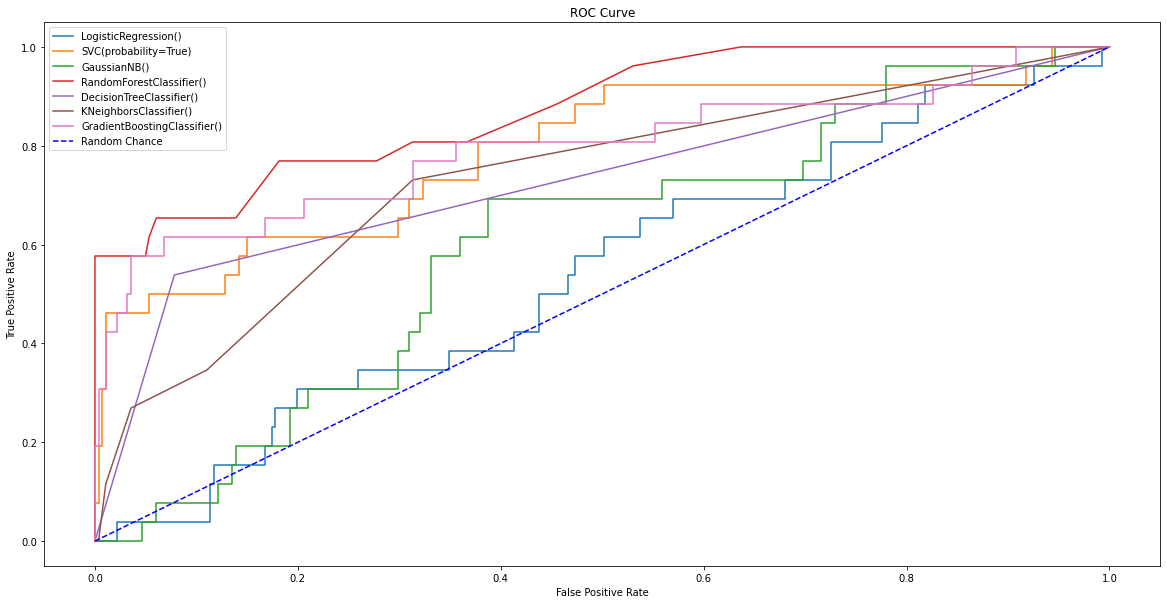

In [26]:
plot_roc_curve(models, data_train, data_test)

### Upsampling

LogisticRegression()
[[179 102]
 [ 15  11]]
SVC(probability=True)
[[242  39]
 [  7  19]]
GaussianNB()
[[130 151]
 [  9  17]]
RandomForestClassifier()
[[280   1]
 [ 12  14]]
DecisionTreeClassifier()
[[247  34]
 [ 10  16]]
KNeighborsClassifier()
[[206  75]
 [  6  20]]
GradientBoostingClassifier()
[[248  33]
 [ 13  13]]


,Model,Accuracy,AUC,Recall,Precision
0,LogisticRegression(),0.618893,0.526690,0.423077,0.097345
1,SVC(probability=True),0.850163,0.808924,0.730769,0.327586
2,GaussianNB(),0.478827,0.595264,0.653846,0.101190
3,"(DecisionTreeClassifier(max_features='auto', r...",0.957655,0.813783,0.538462,0.933333
4,DecisionTreeClassifier(),0.856678,0.747194,0.615385,0.320000
5,KNeighborsClassifier(),0.736156,0.812620,0.769231,0.210526
6,([DecisionTreeRegressor(criterion='friedman_ms...,0.850163,0.742677,0.500000,0.282609


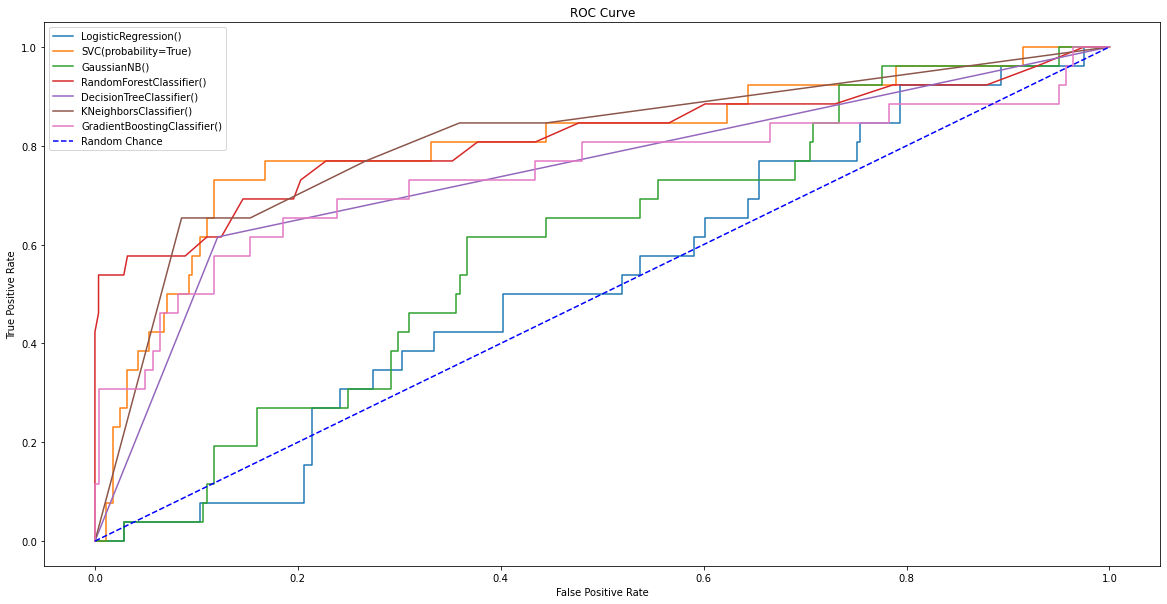

In [27]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=12, sampling_strategy = 1.0)
X_train_upsampled, y_train_upsampled = sm.fit_sample(X_train, y_train)
data_train_upsampled = pd.concat([X_train_upsampled, y_train_upsampled], axis = 1)

plot_roc_curve(models, data_train_upsampled, data_test)